In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from sklearn import metrics
import pickle
from scipy import stats
sns.set_theme()

In [16]:
clubb_dir = '/home/tsw35/tyche/clubb/'
les_dir= '/stor/soteria/hydro/shared/data/tylersclutter/doz_tylertrim/'
daylist=os.listdir(clubb_dir+'sgp_1c')
daylist.sort()
tests=['dpv_lwp','dmv_lwp','dpt_lwp','dt1_lwp','dmv_tke','mdt_lwp']

In [3]:
dbfile = open('../tdata_base.p', 'rb')     
tdata = pickle.load(dbfile)

In [4]:
def cts_to_string(cts):
    out=[]
    for ct in cts:
        sp=str(ct).split('0')
        if(len(sp)<4):
            if 'e-04' in str(ct):
                out.append('cr20ct0.000'+str(ct)[0]+'cf0.8')
            elif 'e-05' in str(ct):
                out.append('cr20ct'+str(ct)+'cf0.8')
        else:
            out.append('cr20ct0.000'+sp[4]+'cf0.8')
    return out

ct_n =np.linspace(.00001,.0005,50,dtype='f4')
ct_s= cts_to_string(ct_n) #filename strings

In [5]:
tdata['circ_pow']=[]
for day in daylist:
    print(day,end='...')
    circ_pow=[]
    for i in range(len(ct_s)):
        f=ct_s[i]
        ct=ct_n[i]
        fp = nc.Dataset(clubb_dir+'circ_tune/'+day[4:]+'/'+f+'/k_2/clusters.nc','r')
        try:
            ur=fp['u_r'][:]
        except:
            circ_pow.append(-1)
            continue
        ur[ur<0]=0
        circ_pow.append(np.sum(ur)*ct)
    circ_pow=np.array(circ_pow)
    tdata['circ_pow'].append(circ_pow)

sgp_20150606...sgp_20150609...sgp_20150627...sgp_20150801...sgp_20150829...sgp_20160518...sgp_20160530...sgp_20160610...sgp_20160611...sgp_20160614...sgp_20160619...sgp_20160625...sgp_20160716...sgp_20160719...sgp_20160720...sgp_20160818...sgp_20160819...sgp_20160830...sgp_20170403...sgp_20170405...sgp_20170509...sgp_20170524...sgp_20170527...sgp_20170605...sgp_20170609...sgp_20170614...sgp_20170626...sgp_20170627...sgp_20170629...sgp_20170630...sgp_20170704...sgp_20170705...sgp_20170709...sgp_20170712...sgp_20170716...sgp_20170717...sgp_20170719...sgp_20170720...sgp_20170721...sgp_20170725...sgp_20170728...sgp_20170802...sgp_20170826...sgp_20170828...sgp_20170830...sgp_20170922...sgp_20170923...sgp_20170924...sgp_20180514...sgp_20180522...sgp_20180523...sgp_20180529...sgp_20180530...sgp_20180531...sgp_20180606...sgp_20180618...sgp_20180619...sgp_20180704...sgp_20180705...sgp_20180707...sgp_20180709...sgp_20180710...sgp_20180711...sgp_20180712...sgp_20180731...sgp_20180805...sgp_201808

In [6]:
def get_lhet(run_dir):
    fp_=open(run_dir+'/tw_run_param.txt','r')
    for line in fp_:
        if 'l_het' in line:
            return float(line.split(' ')[4])
    return 5

In [7]:
def compute_LE(LE,clst_):
    LEclst=np.zeros((LE.shape[0],2))
    for t in range(LE.shape[0]):
        LEclst[t,0]=np.mean(LE[t][clst_==0])
        LEclst[t,1]=np.mean(LE[t][clst_==1])
    return LEclst

In [8]:
lhet=[]
for day in daylist:
    folder=day[4:]
    lhet.append(get_lhet(clubb_dir+'sgp_cpl_m/sgp_'+folder))
print(np.mean(lhet))

30406.26534596935


In [9]:
######################
#### LOAD IN VARS ####
######################
#tdata['vars']['Tsfc']=[]
tdata['vars']['Tatm']=[] # bottom 25
tdata['vars']['rtm']=[] # bottom 25
tdata['vars']['p_blh']=[] # 95pct boundary layer height
tdata['vars']['u_s'] =[] #windspeed
tdata['vars']['d_H'] =[]
#tdata['vars']['u_dir']=[] #wind direction relative to het
tdata['vars']['d_LE']=[]
tdata['vars']['std_H']=[]
#tdata['vars']['lhet']=[]
#tdata['vars']['circ_h']=[]
#tdata['vars']['circ_v']=[]
tdata['vars']['m_H']=[]
tdata['vars']['m_LE']=[]
for day in daylist:
    folder=day[4:]
    fp2c_zt=nc.Dataset(clubb_dir+'sgp_nocpl_m/sgp_'+folder+'/k_2/agg_outzt.nc','r')
    fp2c_zm=nc.Dataset(clubb_dir+'sgp_nocpl_m/sgp_'+folder+'/k_2/agg_outzm.nc','r')
    fp2c_sfc=nc.Dataset(clubb_dir+'sgp_nocpl_m/sgp_'+folder+'/k_2/agg_outsfc.nc','r')
    #fp2c_sfc1=nc.Dataset(clubb_dir+'sgp_nocpl_m/sgp_'+folder+'/k_2/c_1/output/arm_sfc.nc','r')
    #fp2c_sfc2=nc.Dataset(clubb_dir+'sgp_nocpl_m/sgp_'+folder+'/k_2/c_2/output/arm_sfc.nc','r')
    fp2c_clst=nc.Dataset(clubb_dir+'sgp_nocpl_m/sgp_'+folder+'/k_2/clusters.nc','r')
    
    #tdata['vars']['Tsfc'].append(np.mean(fp2c_sfc['T_sfc'][:,0,0,0]))
    tdata['vars']['Tatm'].append(np.mean(fp2c_zt['thlm'][:,0:25,0,0]))
    tdata['vars']['rtm'].append(np.mean(fp2c_zt['rtm'][:,0:25,0,0]))
    tdata['vars']['p_blh'].append(np.percentile(fp2c_sfc['blh'][:,0,0,0],95))
    tdata['vars']['u_s'].append(np.mean((fp2c_zt['um'][:,0:25,0,0]**2+\
                                        fp2c_zt['vm'][:,0:25,0,0]**2)**(1/2)))
    tdata['vars']['d_H'].append(np.abs(np.mean(fp2c_clst['H_clst'][4:7,1])\
                                       -np.mean(fp2c_clst['H_clst'][4:7,0])))
    leclst=compute_LE(fp2c_clst['LE'][:],fp2c_clst['cluster'][0,:,:])
    tdata['vars']['d_LE'].append(np.abs(np.mean(leclst[4:7,1])\
                                       -np.mean(leclst[4:7,0])))
    tdata['vars']['std_H'].append(np.mean(np.std(fp2c_clst['H'][4:7,:,:],axis=(1,2))))
    #tdata['vars']['d_LE'].append(np.mean(np.std(fp2c_clst['LE'][4:10,:,:],axis=(1,2))))
    #tdata['vars']['lhet'].append(get_lhet(clubb_dir+'sgp_cpl_m/sgp_'+folder))
    #tdata['vars']['circ_h']
    #tdata['vars']['circ_v']
    tdata['vars']['m_H'].append(np.mean(fp2c_clst['H'][4:10,:,:]))
    tdata['vars']['m_LE'].append(np.mean(fp2c_clst['LE'][4:10,:,:]))

In [17]:
print(np.array(tdata['tests']['dmv_lwp']).shape)

(92, 50)


In [28]:
tdata_f=np.zeros((92,50),dtype=bool)
tdata_th=np.zeros((92,50))
p_time = 600 #index in time of profile
cut=-2.5
for i in range(92):
    day = daylist[i]
    print(str(i)+'...',end='')
    folder=day[4:]
    fp2czt=nc.Dataset(clubb_dir+'sgp_nocpl_m/sgp_'+folder+'/k_2/agg_outzt.nc','r')
    thlm =np.mean(fp2czt['thlm'][p_time,0:20,0,0])
    for j in range(50):
        f=ct_s[j]
        fp = nc.Dataset(clubb_dir+'circ_tune/'+folder+'/'+f+'/k_2/agg_outzt.nc','r')
        try:
            dthlm=np.mean(fp['thlm'][p_time,0:20,0,0])-thlm
        except:
            dthlm=-100
        if dthlm>cut:
            tdata_f[i,j]=True
        tdata_th[i,j]=dthlm

            

0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...

In [29]:
def tindex_to_cpow(tindex,circ_pow):
    cpow=[]
    for i in range(len(tindex)):
        try:
            cpow.append(circ_pow[i][tindex[i]])
        except:
            cpow.append(float('nan'))
    return cpow

dpv_lwp: 1.0/16.0/18.0
dmv_lwp: 0.0/21.0/22.0
dpt_lwp: 0.0/26.0/8.0
dt1_lwp: 1.0/34.0/31.0
dmv_tke: 0.0/32.0/41.0
mdt_lwp: 0.0/19.0/8.0


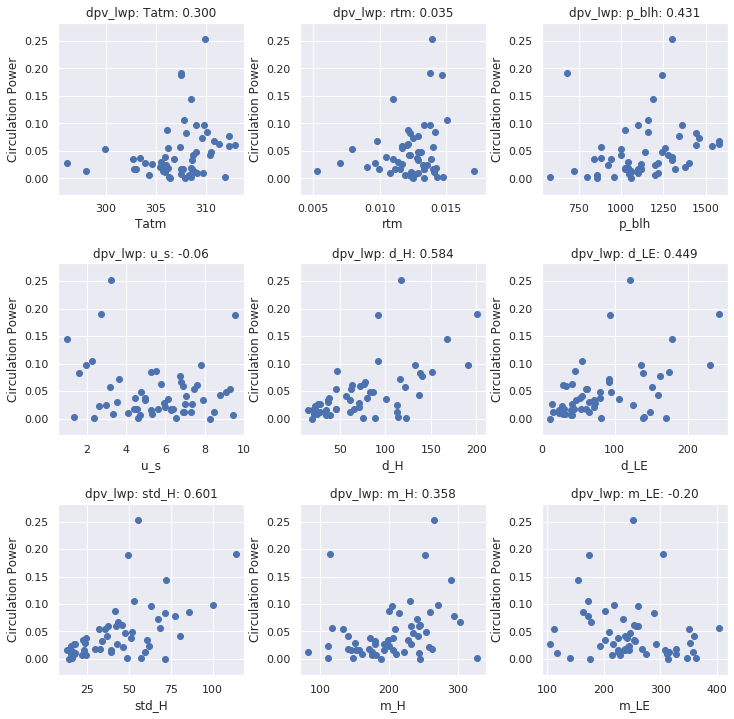

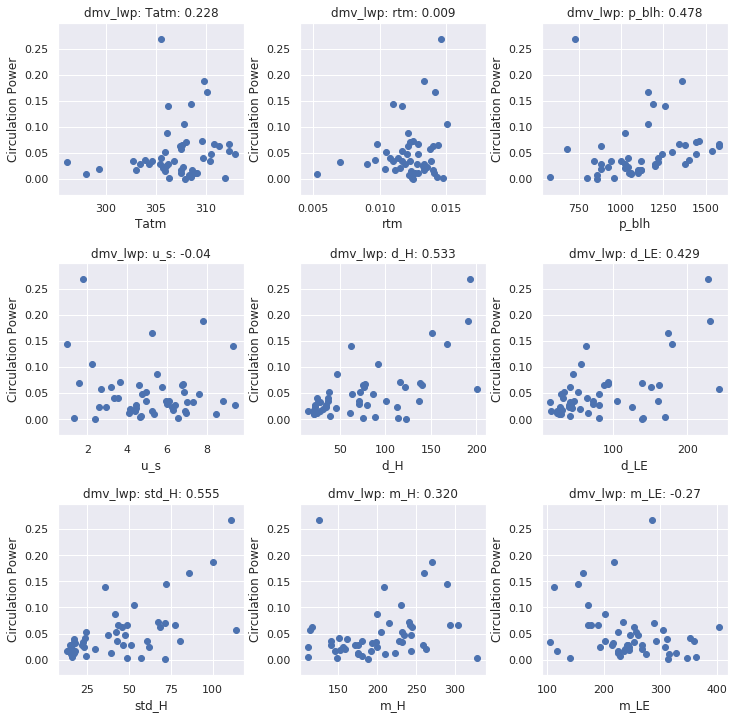

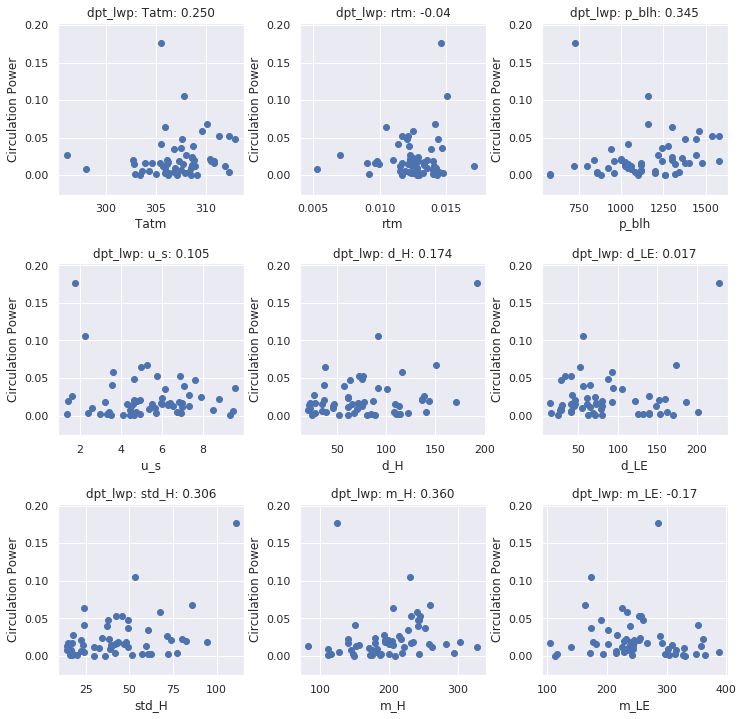

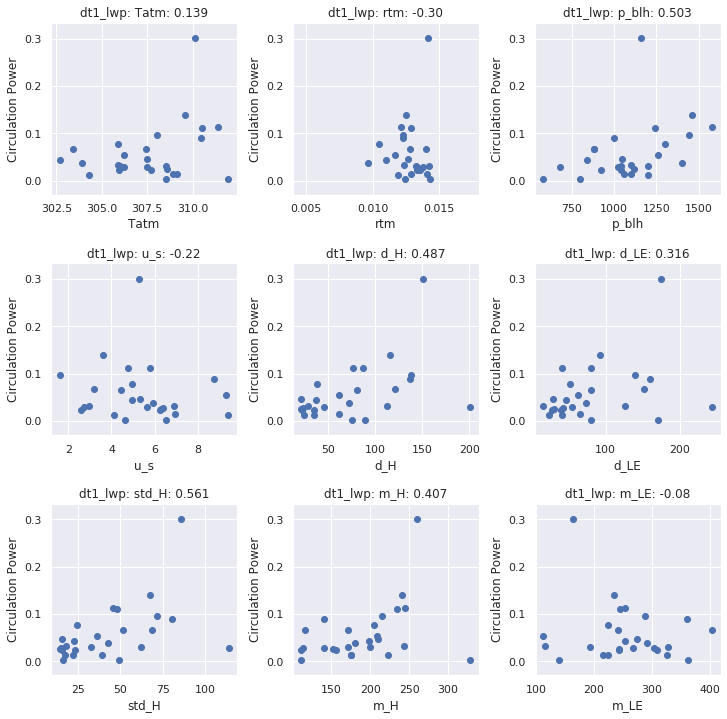

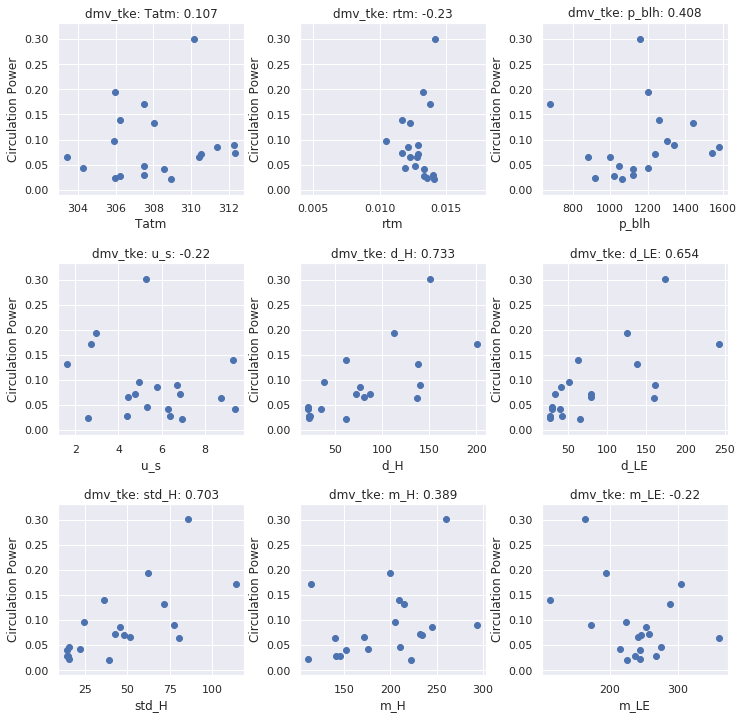

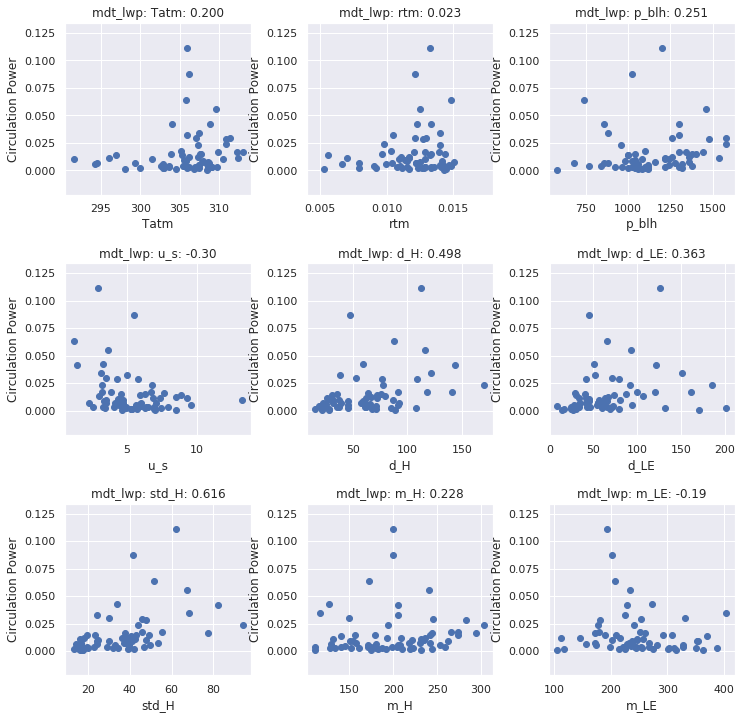

In [119]:
x=0
cut=-1
for test in tests:
    zero_count=0
    nan_count=0
    bad_count=0
    plt.figure(figsize=(12,12))
    i=1
    for var in tdata['vars'].keys():
        ax=plt.subplot(3,3,i)
        #ax.set_yscale("log")
        i=i+1
        cv=[]
        ct=[]
        cvv=tdata['vars'][var][:]
        ct_=tdata['ct_pct50'][test][:]
        ctt=(tindex_to_cpow(ct_,tdata['circ_pow'][:]))
        for j in range(len(tdata['vars'][var][:])):
            if np.isnan(cvv[j]) or np.isnan(ctt[j]):
                nan_count=nan_count+1
                continue
            elif (ctt[j]<=0.0):
                zero_count=zero_count+1
                continue
            elif not (tdata_th>cut)[j,ct_[j]]:
                bad_count=bad_count+1
                continue
            else:
                cv.append(cvv[j])
                ct.append(ctt[j])
        plt.scatter(cv,ct)
        pr=stats.spearmanr(cv, ct)[0]
        plt.title(test+': '+var+': '+str(pr)[0:5])
        plt.xlabel(var)
        plt.ylabel('Circulation Power')
        if var =='rtm':
            plt.xlim(0.004,.018)
        #plt.ylim(10**(-4),1)
        #plt.ylim(tliml[x],tlimh[x])
    print(test+': '+str(zero_count/9)+'/'+str(nan_count/9)+'/'+str(bad_count/9))
    plt.subplots_adjust(hspace=.4,wspace=.3)
    x=x+1

In [35]:
def const_circ_pow(circ_pows,val,test):
    testvals=[]
    cps=[]
    ass=[]
    for i in range(92):
        cp=np.array(circ_pows[i])
        a = np.argmin(np.abs(cp-val))
        if (a>=49) or (a<1):
            testvals.append(float('nan'))
            cps.append(float('nan'))
            ass.append(float('nan'))
        else:
            testvals.append(test[i,a])
            cps.append(cp[a])
            ass.append(a)
    return testvals,cps,ass

2.0
2.0
2.0
2.0
2.0
2.0


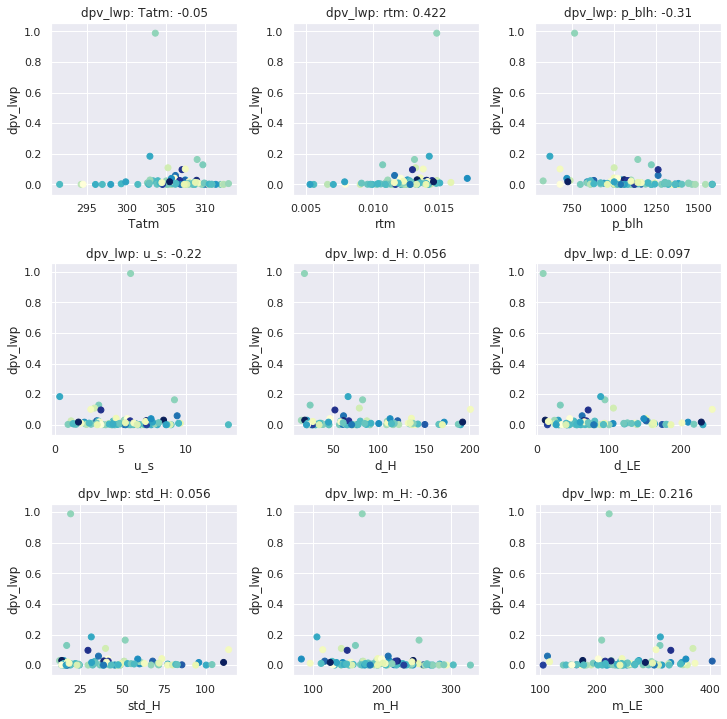

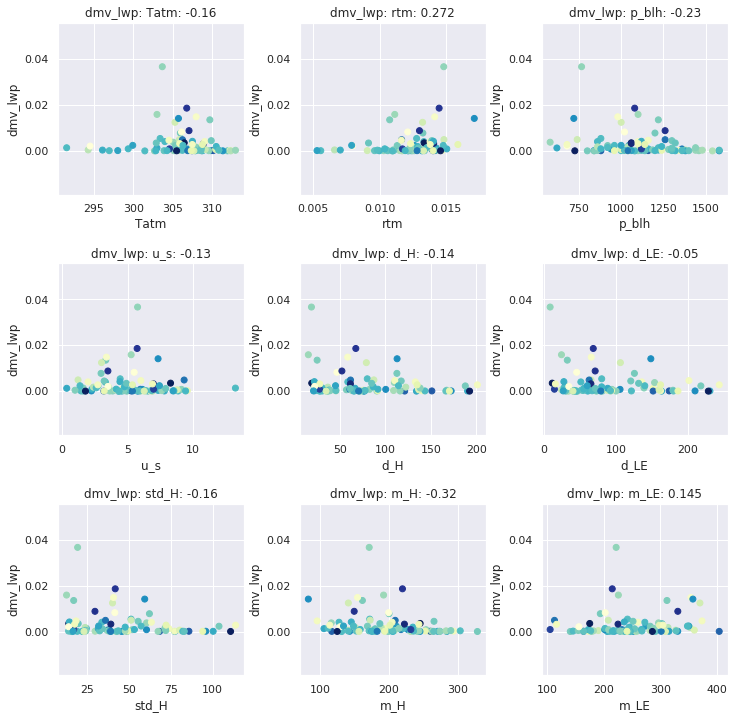

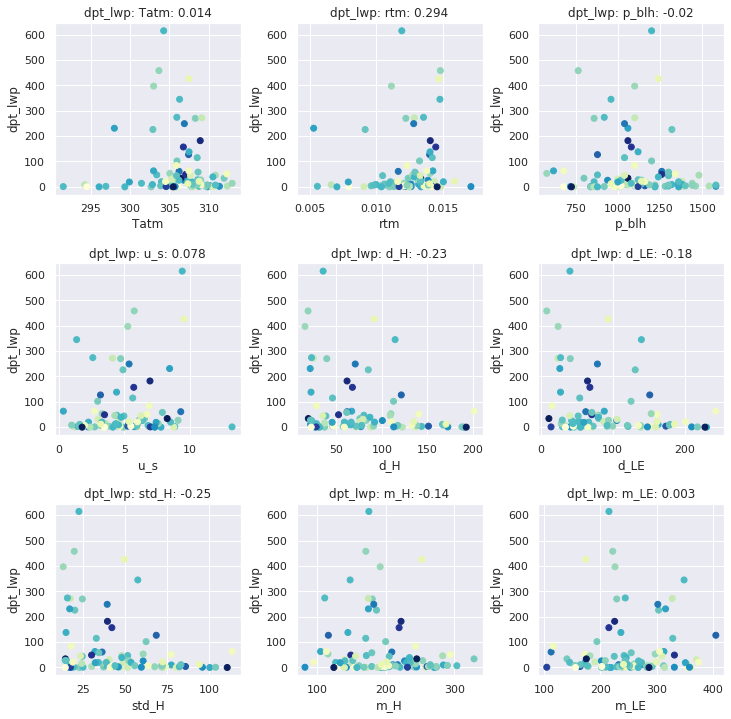

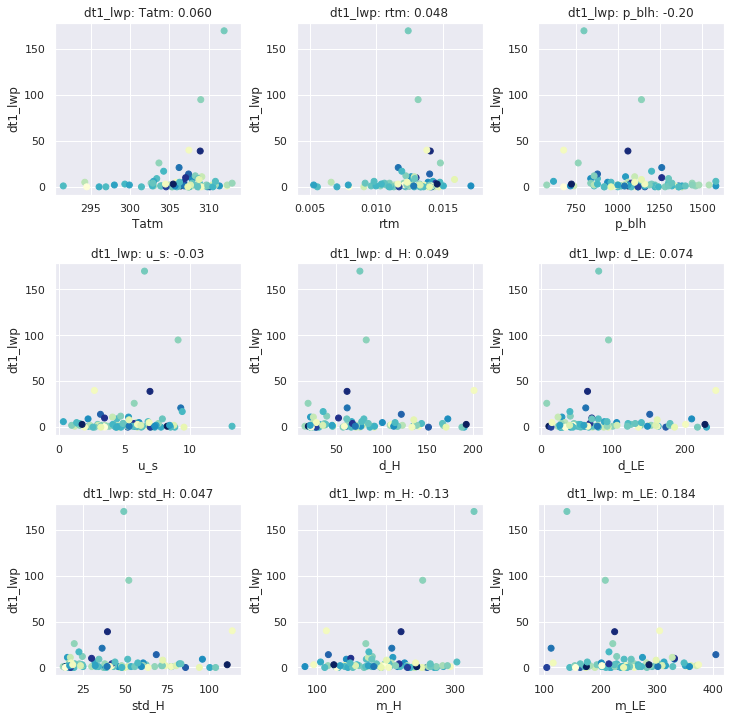

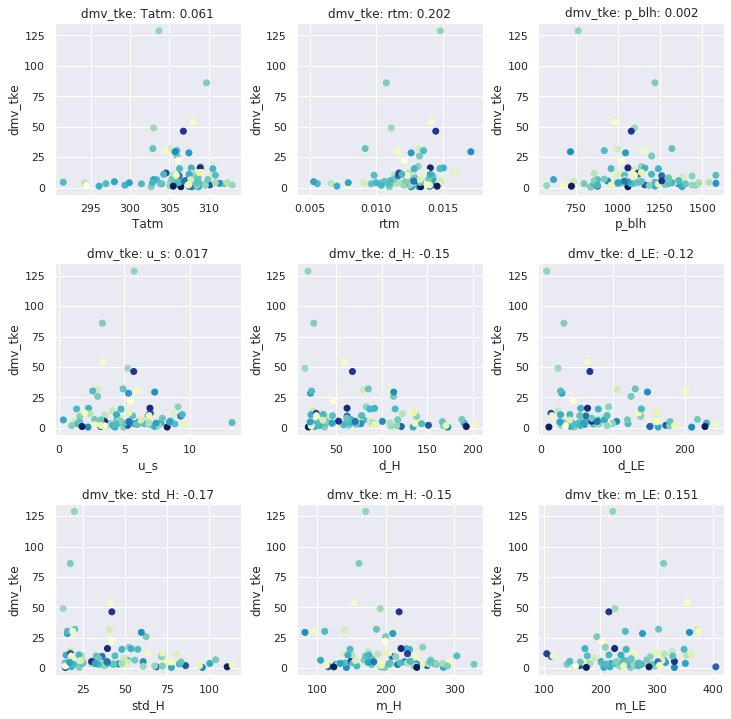

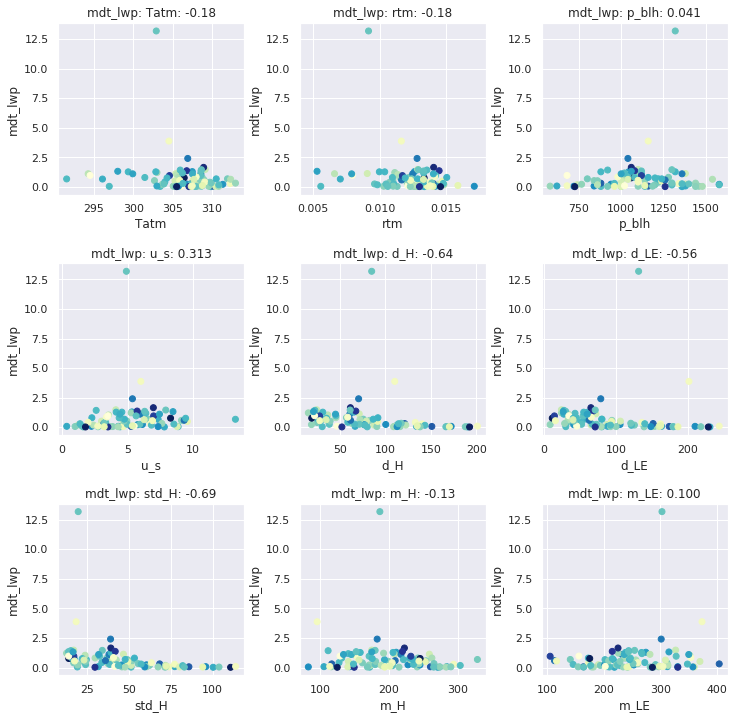

In [54]:
cut=-1
for test in tests:
    plt.figure(figsize=(12,12))
    i=1
    bad_count=0
    for var in tdata['vars'].keys():
        plt.subplot(3,3,i)
        v=tdata['vars'][var][:]
        t,cp,ass=const_circ_pow(tdata['circ_pow'][:],.02,np.abs(np.array(tdata['tests'][test][:])))
        i=i+1
        cv=[]
        ct=[]
        cp2=[]
        for j in range(len(tdata['vars'][var][:])):
            if np.isnan(t[j]) or np.isnan(v[j]):
                continue
            elif not (tdata_th>cut)[j,ass[j]]:
                bad_count=bad_count+1
                continue
            else:
                cv.append(v[j])
                ct.append(t[j])
                cp2.append(cp[j])
        color=plt.cm.YlGnBu((cp2-np.min(cp2))/(np.max(cp2)-np.min(cp2)))
        plt.scatter(cv,ct,color=color)
        pr=stats.spearmanr(cv,ct)[0]
        plt.title(test+': '+var+': '+str(pr)[0:5])
        plt.xlabel(var)
        plt.ylabel(test)
        if var =='rtm':
            plt.xlim(0.004,.018)
        #plt.ylim(-10,10)
    plt.subplots_adjust(hspace=.4,wspace=.3)
    print(bad_count/9)

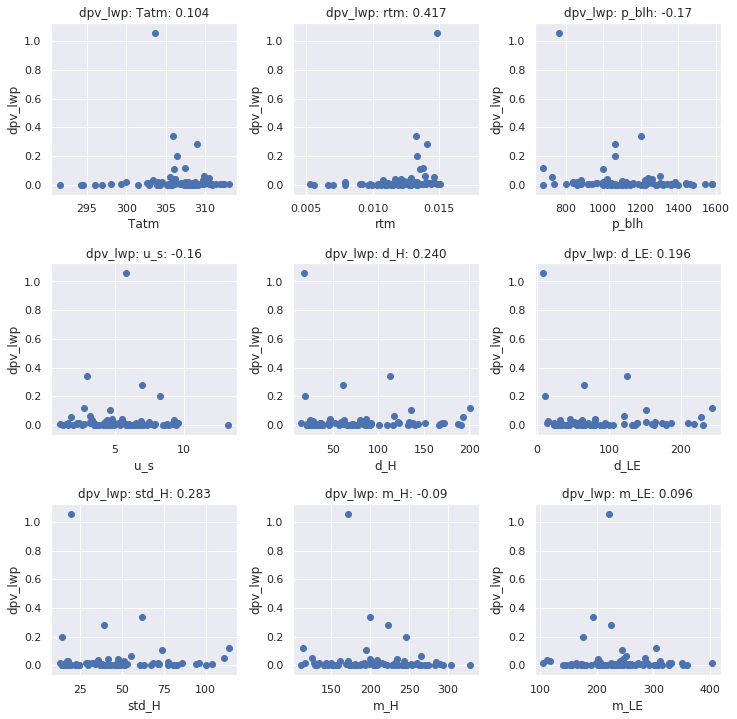

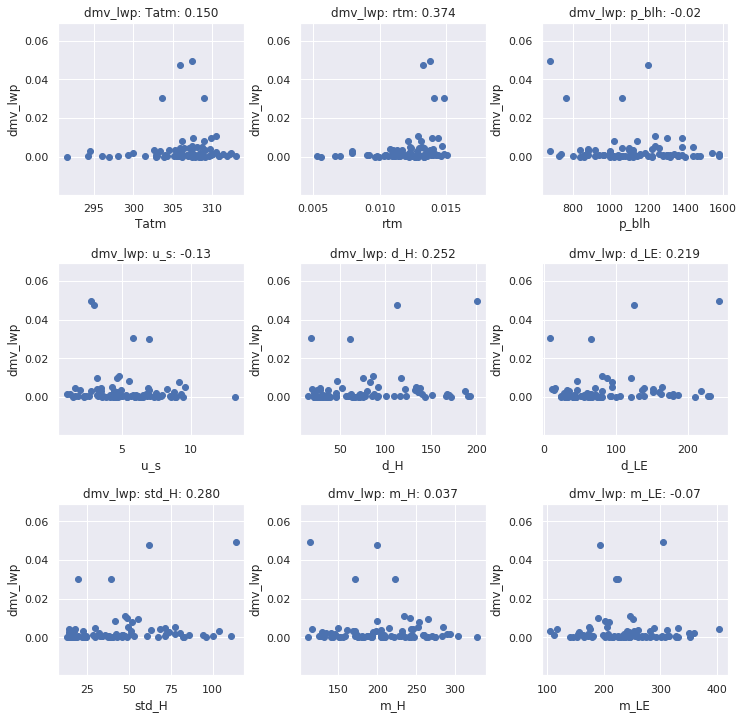

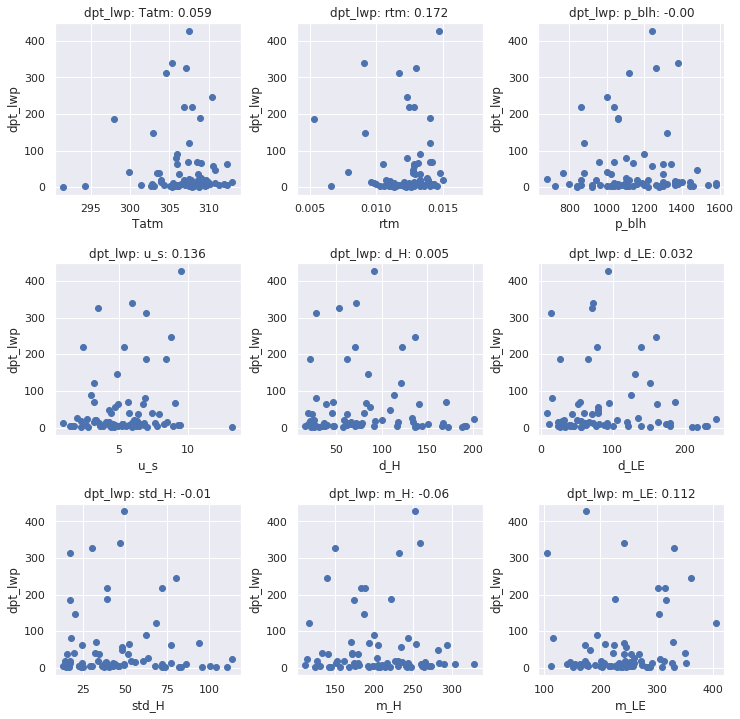

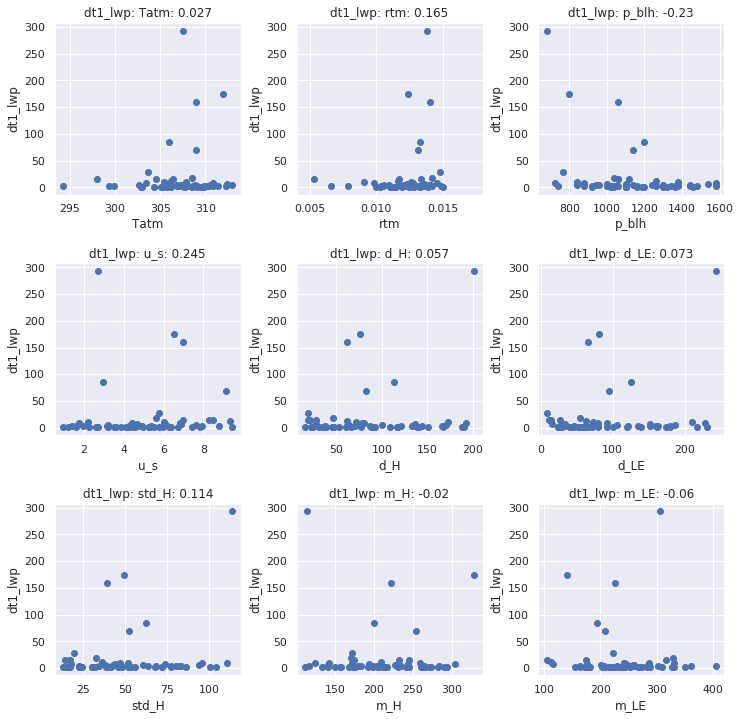

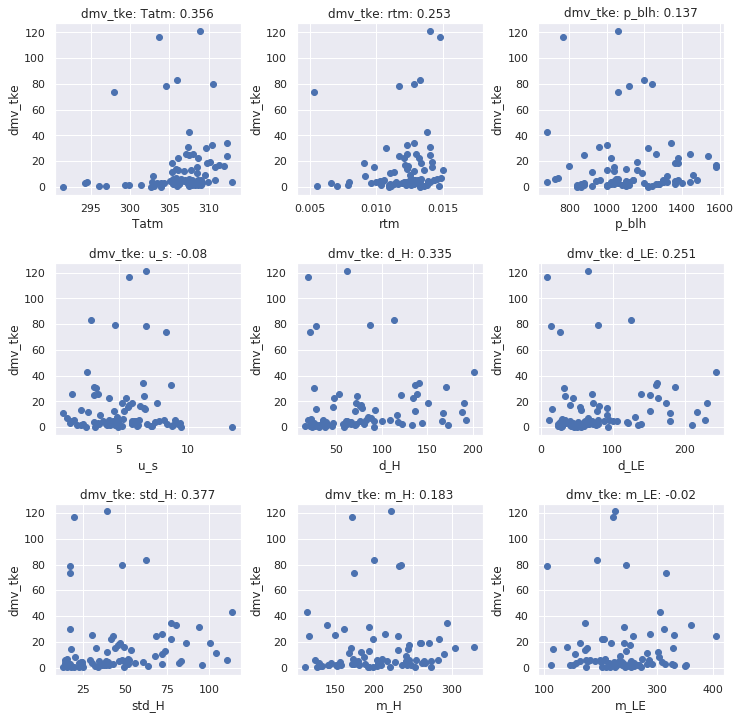

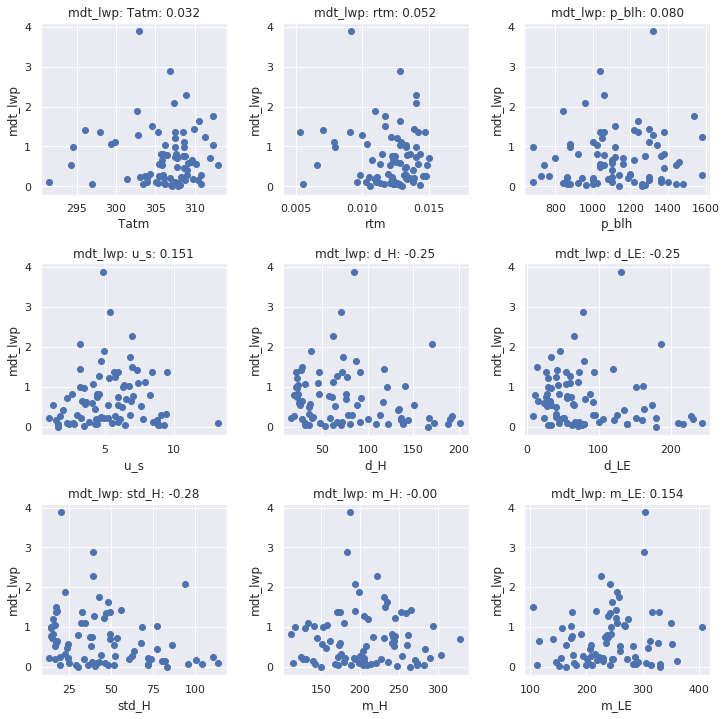

In [58]:
val=15
for test in tests:
    plt.figure(figsize=(12,12))
    i=1
    for var in tdata['vars'].keys():
        plt.subplot(3,3,i)
        cvv=tdata['vars'][var][:]
        ctt=np.abs(np.array(tdata['tests'][test])[:,val])
        v=[]
        t=[]
        for j in range(len(tdata['vars'][var][:])):
            if np.isnan(cvv[j]) or np.isnan(ctt[j]):
                nan_count=nan_count+1
                continue
            elif (ctt[j]<=0.0):
                zero_count=zero_count+1
                continue
            elif not (tdata_th>cut)[j,val]:
                bad_count=bad_count+1
                continue
            else:
                v.append(cvv[j])
                t.append(ctt[j])
        plt.scatter(v,t)
        i=i+1
        pr=stats.spearmanr(v,t)[0]
        plt.title(test+': '+var+': '+str(pr)[0:5])
        plt.xlabel(var)
        plt.ylabel(test)
        if var =='rtm':
            plt.xlim(0.004,.018)
    plt.subplots_adjust(hspace=.4,wspace=.3)

In [62]:
fp=nc.Dataset(les_dir+'trimdoz_20170705_01.nc','r')
dt1 = datetime.datetime(2016,1,1,0,0)
times_js = []
for t in range(len(fp['time'][:])):
    times_js.append(dt1+datetime.timedelta(minutes=int(fp['time'][t]))-datetime.timedelta(hours=5))
    
dt1 = times_js[0]
dt1 = dt1-datetime.timedelta(hours=dt1.hour)+datetime.timedelta(hours=7)
fp=nc.Dataset(clubb_dir+'sgp_1c/sgp_20180618/k_1/c_1/output/arm_sfc.nc','r')
times_clb1 = []
for t in range(len(fp['time'][:])):
    times_clb1.append(dt1+datetime.timedelta(seconds=int(t*60)))

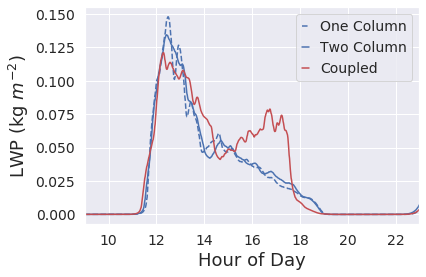

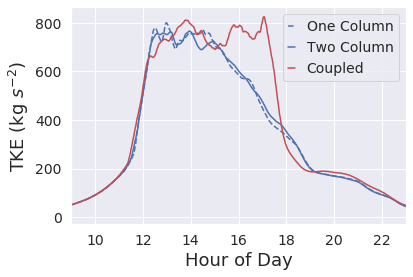

In [115]:
######### PRESENTATION PLOTS ###########
ftlrg=18
ftsml=14
times_clb1=np.linspace(7,23,955)
day='20170721'
daystr='2018-07-09'
i=22
f=ct_s[i]
ct=ct_n[i]
fp = nc.Dataset(clubb_dir+'circ_tune/'+day+'/'+f+'/k_2/agg_outsfc.nc','r')
fp2c=nc.Dataset(clubb_dir+'sgp_nocpl_m/sgp_'+day+'/k_2/agg_outsfc.nc','r')
fp1c=nc.Dataset(clubb_dir+'sgp_1c/sgp_'+day+'/k_1/c_1/output/arm_sfc.nc','r')
fpz = nc.Dataset(clubb_dir+'circ_tune/'+day+'/'+f+'/k_2/agg_outzm.nc','r')
fp2cz=nc.Dataset(clubb_dir+'sgp_nocpl_m/sgp_'+day+'/k_2/agg_outzm.nc','r')
fp1cz=nc.Dataset(clubb_dir+'sgp_1c/sgp_'+day+'/k_1/c_1/output/arm_zm.nc','r')
lwp=fp['lwp'][:,0,0,0]
lwp2c=fp2c['lwp'][:,0,0,0]
lwp1c=fp1c['lwp'][:,0,0,0]
tke=np.sum(fpz['wp2'][:,:,0,0]+fpz['up2'][:,:,0,0]+fpz['vp2'][:,:,0,0],axis=1)
tke2c=np.sum(fp2cz['wp2'][:,:,0,0]+fp2cz['up2'][:,:,0,0]+fp2cz['vp2'][:,:,0,0],axis=1)
tke1c=np.sum(fp1cz['wp2'][:,:,0,0]+fp1cz['up2'][:,:,0,0]+fp1cz['vp2'][:,:,0,0],axis=1)

fig,ax=plt.subplots()
plt.plot(times_clb1,lwp1c,'b--')
plt.plot(times_clb1,lwp2c,'b')
plt.plot(times_clb1,lwp,'r')
#plt.title('LWP',fontsize=ftlrg)
#plt.ylim(0,.25)
plt.xlim(9,23)
plt.xlabel('Hour of Day',fontsize=ftlrg)
plt.ylabel('LWP (kg $m^{-2})$',fontsize=ftlrg)
plt.legend(['One Column','Two Column','Coupled'],fontsize=ftsml,handlelength=.5)
ax.tick_params(axis='both', which='major', labelsize=ftsml)

fig,ax=plt.subplots()
plt.plot(times_clb1,tke1c,'b--')
plt.plot(times_clb1,tke2c,'b-')
plt.plot(times_clb1,tke,'r')
plt.xlim(9,23)
plt.xlabel('Hour of Day',fontsize=ftlrg)
plt.ylabel('TKE (kg $s^{-2}$)',fontsize=ftlrg)
plt.legend(['One Column','Two Column','Coupled'],fontsize=ftsml,handlelength=.5)
ax.tick_params(axis='both', which='major', labelsize=ftsml)


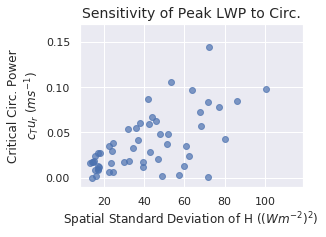

In [139]:
fig,ax=plt.subplots(figsize=(4,3))
#ax.set_yscale("log")
test='dpv_lwp'
var='std_H'
i=i+1
cv=[]
ct=[]
cvv=tdata['vars'][var][:]
ct_=tdata['ct_pct50'][test][:]
ctt=(tindex_to_cpow(ct_,tdata['circ_pow'][:]))
for j in range(len(tdata['vars'][var][:])):
    if np.isnan(cvv[j]) or np.isnan(ctt[j]):
        nan_count=nan_count+1
        continue
    elif (ctt[j]<=0.0):
        zero_count=zero_count+1
        continue
    elif not (tdata_th>cut)[j,ct_[j]]:
        bad_count=bad_count+1
        continue
    else:
        cv.append(cvv[j])
        ct.append(ctt[j])
plt.scatter(cv,np.array(ct),alpha=.7)
pr=stats.spearmanr(cv, ct)[0]
#plt.title(test+': '+var+': '+str(pr)[0:5])
#plt.xlabel(var)
plt.xlabel('Spatial Standard Deviation of H ($(W m^{-2})^{2}$)')
plt.ylim(-.01,.17)
plt.ylabel('Critical Circ. Power\n$c_{T} u_r$ $(m s^{-1})$')
plt.title('Sensitivity of Peak LWP to Circ.',fontsize=14)
if var =='rtm':
    plt.xlim(0.004,.018)